Bu not defterinde, Dijkstra'nın arama algoritmasını bir yol ağında uygulama fırsatı verilecektir. Daha sonra, A* araması yapmak için bir distance heuristic yöntemi kullanarak bu algoritmayı değiştireceksiniz. Daha sonra, en kısa yolunuzu haritalama kütüphanesinin yoluyla karşılaştırma şansına sahip olacaksınız.

**Bu not defterinde, şunları yapacaksınız:**
* Dijkstra'nın arama algoritmasını bir yol ağı grafiğinde uygulayacaksınız.
* A* arama algoritmasını bir yol ağı grafiğinde Öklid buluşsal yöntemini kullanarak uygulayacaksınız.

Size önerilen bir taslak sunulur. Bir sorunu çözmenin daha iyi, daha verimli bir yolu olduğunu düşünüyorsanız, taslaktan sapmanız önerilir.

Bu değerlendirmede, Open Street Map (OSM) verilerinden Python grafikleri oluşturmak için [OSMNX kütüphanesine](https://osmnx.readthedocs.io/en/stable/) güveneceğiz. Bu grafikler [NetworkX kütüphanesi](https://networkx.github.io/documentation/stable/) kullanılarak temsil edilecektir. Bu bağlantıların her ikisi de bu değerlendirmede faydalı bulacağınız belgelere aittir.

In [1]:
import osmnx as ox
import networkx as nx
import queue
import math
import priority_dict

Aşağıdaki kod ox kütüphanesi ile Open Street Map'den belirli bir bölgenin haritasını alıyor ve bu harita üzerinde bulunan iki nokta arasındaki yolun çıktısını gösteriyor. Dijkstra ve A* kodları da aynı çıktıyı göstermeli.

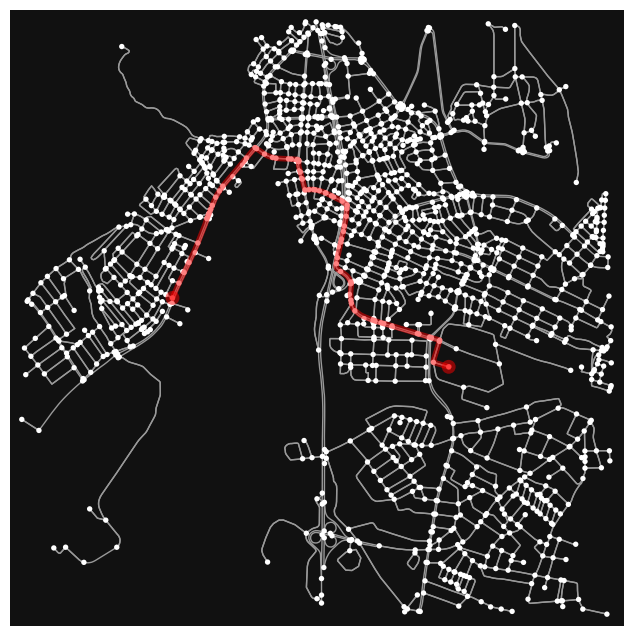

In [2]:
map_graph = ox.graph_from_point(center_point = (39.78394, 32.80378), dist = 2500 ,network_type='drive') # ('Gölbaşı merkez', network_type='drive')
origin = ox.nearest_nodes(map_graph, Y= 39.780240, X= 32.816827)#39.780240, 32.816827
destination =  ox.nearest_nodes(map_graph, Y= 39.785540, X= 32.790327)#39.780240, 32.816827

shortest_path = nx.shortest_path(map_graph, origin, destination, weight='length')
fig, ax = ox.plot_graph_route(map_graph, shortest_path)



## Dijkstra's Search
<div style="display: flex; align-items: center;">
<div style="max-width: 800px; margin-left: 10; margin-right: auto; display: block;">

Bu fonksiyon aşağıda `dijkstra_search()` içinde sizin tarafınızdan uygulanacaktır.  
Hedef bulunduğunda öncüllerin sözlüğünden yolu almaya yardımcı olacak bir yardımcı fonksiyon `get_path()` ekledik.

Dijkstra aramasını gerçekleştirmek için, `priority_dict` sınıfı olarak tanımlanan bir öncelik kuyruğuna (veya bir min yığınına) ihtiyacımız var.  
Bu sınıfa, anahtarları değerlerine göre sıralayan standart bir sözlükle aynı şekilde erişilir.

Öncelik kuyruğumuzun anahtarları olarak vertex'leri ve değerleri olarak başlangıçtan uzaklıklarını kullanabiliriz.  
Örneğin, vertex `v`'nin mesafesini `dist` değişkenine ayarlamak için `open_queue[v] = dist` yapabiliriz.

Öncelik kuyruğundaki en küçük değeri elde etmek için `priority_dict.pop_smallest()` kullanabiliriz.  
Bu, vertex anahtarının ve orijinden uzaklığının bir tuple'ını döndürür.

Aramanın ana girdisi, yol ağının OSMNX grafik gösterimi olan `graph`'tır. Vertex'ler anahtarlar olarak saklanır ve bu nedenle başlangıç ​​noktası `origin_key` girdisi olarak verilir ve hedef `goal_key` olarak verilir. Verilen bir vertex'in giden kenarlarını almak için `graph.out_edges([u], data=True)` kullanabiliriz. Bunun dönüş değeri, her biri giden bir kenarı temsil eden bir dizi tuple'dır. Her tuple'ın ikinci elemanı, kenarın diğer ucundaki giden vertex'tir.

Bu diziler listesi üzerinde şunları kullanarak yineleme yapabilirsiniz:

```python
for edge in graph.out_edges([u], data=True):
```

Ve bu kenarın çıkış vertex'ini, tuple'ın 2. elemanına erişerek elde edebiliriz:

```python
edge[1]
```

Bu kenarın ağırlığını almak için, tuple'ın 3. elemanında saklanan verilere erişebilirsiniz:

```python
length = edge[2]['length']
```

Daha fazla ayrıntı için [buradaki](https://networkx.github.io/documentation/networkx-2.3/reference/classes/generated/networkx.DiGraph.out_edges.html?highlight=out_edges#networkx.DiGraph.out_edges) NetworkX belgelerine başvurabilirsiniz.

Şimdiki amacınız, Dijkstra aramasını kullanarak grafikte başlangıç ​​vertex'inden hedefe en kısa yolu bulmaktır. Her bir vertex'in en iyi öncüllerini `predecessors` sözlüğüne kaydettiğinizden emin olun, böylece aramanızda hedef düğümü bulduğunuzda en iyi yolu alabilirsiniz. İyi şanslar!


</div>
<img src="documents/dijkstra.png" alt="Dijkstra algoritması"  width="700" >

</div>

In [3]:
# Verilen bir grafik, başlangıç vertex anahtarı ve hedef vertex anahtarı için,
# Dijkstra algoritmasını kullanarak başlangıç vertex'inden hedef vertex'ine
# en kısa yolu hesaplar.
# En kısa yolu vertex anahtarları listesi olarak döndürür.
def dijkstras_search(origin_key, goal_key, graph):
    print(origin_key)
    print(goal_key)
    
    # Ulaşılan açık vertexlerin öncelik kuyruğu.
    # Anahtarlar vertex anahtarları, değerler ise mesafeler.
    open_queue = priority_dict.priority_dict({})
    # İşlenmiş kapalı vertexlerin sözlüğü.
    closed_dict = {}
    
    # Her vertex için önceki vertexlerin sözlüğü.
    predecessors = {}
    
    # Başlangıç vertex'ini açık kuyruğa ekle.
    open_queue[origin_key] = 0.0

    # Açık kuyruk üzerinde, hedefi bulana kadar döngüye gir.
    # Her seferinde, kuyruk üzerinde Dijkstra güncellemesi yapılır.
    # TODO: Dijkstra güncelleme döngüsünü implement et.
    goal_found = False
    while (open_queue):
        u , uCost = open_queue.pop_smallest()
        
        if (u == goal_key): # Eğer hedef vertex bulunursa
            goal_found = True
            break
            
        # Ulaşılabilir komşu vertexler üzerinde işlem yap.
        for edge in graph.out_edges([u], data=True):
    
            if edge[1] in closed_dict: # Eğer komşu vertex zaten kapalı listede ise
                continue
            
            # Kenarın uzunluğunu al.
            length = edge[2]['length']
            
            # Eğer komşu vertex açık kuyrukta ise
            if edge[1] in open_queue: 
                # Eğer yeni bulunan yol daha kısa ise, mesafeyi güncelle.
                if (uCost + length) < open_queue[edge[1]]:
                    open_queue[edge[1]] = uCost + length
                    predecessors[edge[1]] = u
            else:
                # Eğer komşu vertex açık kuyrukta değilse, onu ekle.
                open_queue[edge[1]] = uCost + length
                predecessors[edge[1]] = u
        
        # Şu anki vertex'i kapalı listeye ekle.
        closed_dict[u] = 0
    
    # Eğer tüm öncelik kuyruğu üzerinde hedef bulunamazsa,
    # bir şeyler ters gitmiştir.
    if not goal_found:
        raise ValueError("Hedef arama sırasında bulunamadı.")
    
    # Önceki vertexler sözlüğünü kullanarak yolu oluştur.
    return get_path(origin_key, goal_key, predecessors)

In [4]:
# Bu fonksiyon, predecessor (öncül) göstergelerini takip ederek
# başlangıç noktasından hedefe kadar olan yolu bir vertex anahtarları listesi
# olarak döndürür.
def get_path(origin_key, goal_key, predecessors):
    key = goal_key
    path = [goal_key]
    
    # Hedefe ulaşıldığında, origin_key (başlangıç noktası) ile karşılaşana kadar
    # predecessors sözlüğünden her bir vertex'in öncülünü takip ederiz.
    while (key != origin_key):
        key = predecessors[key]  # Şu anki vertex'in öncülünü al
        path.insert(0, key)  # Yeni vertex'i yolun başına ekle
    
    # Bulunan yolu, başlangıç noktasından hedefe doğru olan vertex'ler listesi olarak döndür
    return path

Bu iki işlev uygulandıktan sonra, çıktınızın yukarıdaki kütüphane işleviyle eşleşip eşleşmediğini görmek için aşağıdaki kutuyu çalıştırın. Eşleşmiyorsa, uygulamanızda bir hata yapmışsınızdır.

3714654055
9010909219


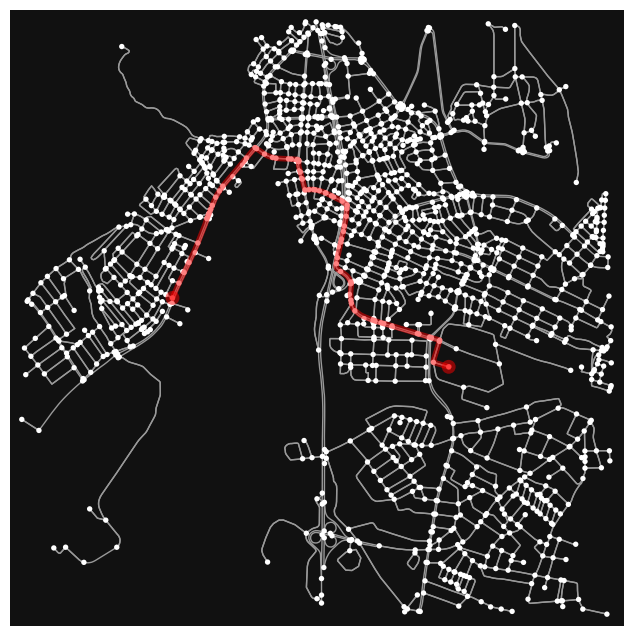

In [5]:
path = dijkstras_search(origin, destination, map_graph)        
fig, ax = ox.plot_graph_route(map_graph, path) 

## A* Search
<div style="display: flex; align-items: center;">
<div style="max-width: 1000px; margin-left: 10; margin-right: auto; display: block;">
Harita arama problemimiz için A* aramasını uygulamak üzere bir "distance heuristic" kullanacağız.

Burada gerçek harita verileri kullandığımız için, verileri mesafe hesaplaması için kullanabileceğimiz bir biçime dönüştürmemiz gerekecek.

Her veri noktasının kendisiyle ilişkili bir enlem ve boylamı vardır ve bunları daha sonra dünyadaki (x, y, z) koordinatlarına dönüştürmemiz gerekir (yarıçapı 6371 km olan bir küre olduğunu varsayacağız).

Daha sonra bu iki nokta arasındaki düz çizgi mesafesini, aralarındaki mesafe için bir yaklaşım olarak alabiliriz.

Küçük mesafelerde, bu yaklaşım doğrudur. Bu, aşağıdaki `distance_heuristic()` fonksiyonunda uygulanır.
</div>
</div>

In [6]:
# İki vertex arasındaki Öklidyen mesafeyi hesaplar.
# Dünya'nın bir küre olduğunu varsayarız ve yarıçapı 6371 km'dir.
def distance_heuristic(state_key, goal_key, node_data):
    n1 = node_data[state_key]  # Başlangıç vertex'inin verilerini al
    n2 = node_data[goal_key]   # Hedef vertex'inin verilerini al

    # Her iki vertex için boylam (longitude) ve enlem (latitude) değerlerini al.
    # Dönüşüm: dereceyi radyana çeviriyoruz (derece * π / 180)
    long1 = n1['x'] * math.pi / 180.0
    lat1 = n1['y'] * math.pi / 180.0
    long2 = n2['x'] * math.pi / 180.0
    lat2 = n2['y'] * math.pi / 180.0
    
    # Dünya'nın küresel bir yaklaşık modelini kullanarak
    # iki nokta arasındaki mesafeyi tahmin ederiz.
    r = 6371000  # Dünya'nın yarıçapı, metre cinsinden (6371 km * 1000)
    
    # Vertex 1'in 3D kartesyen koordinatlarını hesapla
    x1 = r * math.cos(lat1) * math.cos(long1)
    y1 = r * math.cos(lat1) * math.sin(long1)
    z1 = r * math.sin(lat1)

    # Vertex 2'nin 3D kartesyen koordinatlarını hesapla
    x2 = r * math.cos(lat2) * math.cos(long2)
    y2 = r * math.cos(lat2) * math.sin(long2)
    z2 = r * math.sin(lat2)

    # İki vertex arasındaki 3D mesafeyi hesapla
    d = ((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2) ** 0.5
    
    # Hesaplanan mesafeyi döndür
    return d


<div style="display: flex; align-items: center;">
<img src="documents/a_star.png" alt="Dijkstra algoritması"  width="700" >

<div style="max-width: 800px; margin-left: auto; margin-right: auto; display: block;">
Şimdi, mesafe sezgimizi kullanarak haritamızda A* araması yapabiliriz.

Bu fonksiyon, aşağıda `a_star_search()` fonksiyonunda uygulanacaktır. Daha önce olduğu gibi, `get_path()` yardımcı fonksiyonunu kullanmalısınız. 

Daha önce olduğu gibi, grafikte başlangıç noktasından hedefe en kısa yolu bulmalısınız, ancak bu sefer A* algoritmasını ve yukarıda verilen mesafe sezgisini kullanmalısınız. 

İyi şanslar!
</div>
</div>

In [ ]:
# Verilen bir grafik, başlangıç vertex anahtarı ve hedef vertex anahtarı için,
# A* araması kullanarak grafikteki başlangıç vertex'inden hedef vertex'ine
# en kısa yolu hesaplar. 
# En kısa yolu vertex anahtarları listesi olarak döndürür.
def a_star_search(origin_key, goal_key, graph):
    # Ulaşmaya çalıştığımız açık vertex'lerin öncelik kuyruğu.
    # Anahtarlar vertex anahtarları, değerler ise birikmiş mesafeler
    # artı hedefe olan mesafe tahminini içerir.
    open_queue = priority_dict.priority_dict({})

    # İşlemden geçirilmiş kapalı vertex'lerin sözlüğü.
    closed_dict = {}

    # Her vertex için öncül vertex'lerin sözlüğü.
    predecessors = {}

    # Her vertex'e ulaşmak için en iyi maliyetin saklandığı sözlük.
    costs = {}

    # Her vertex'in coğrafi verilerini bir sözlük olarak al.
    node_data = graph.nodes(True)

    # Başlangıcı açık kuyruğa ve maliyetler sözlüğüne ekle.
    costs[origin_key] = 0.0
    open_queue[origin_key] = distance_heuristic(origin_key, goal_key, node_data)

    # Açık kuyruğu üzerinde, hedefe ulaşana kadar iterasyon yap.
    # Her adımda, A* kuyruğunu güncelle.
    goal_found = False
    while open_queue:
        pass

    # Eğer hedef bulunmazsa, hata fırlat.
    if not goal_found:
        raise ValueError("Goal not found in search.")

    # Predecessors (öncüller) sözlüğünden yolu oluştur.
    return get_path(origin_key, goal_key, predecessors)


Bu işlev uygulandıktan sonra, çıktınızın not defterinin başlangıcındaki kütüphane işleviyle eşleşip eşleşmediğini görmek için aşağıdaki kutuyu çalıştırın. Eşleşmiyorsa, uygulamanızda bir hata yapmışsınız demektir.

In [ ]:
path = a_star_search(origin, destination, map_graph)        
fig, ax = ox.plot_graph_route(map_graph, path) 